In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import joblib

EMA explanation

In [2]:
def prepare_stock_data(stock):
    df = pd.read_json('../data/historical_data/' + stock + '.json', lines=True)
    df1 = pd.read_json('../data/historical_data/S&P500.json', lines=True)

    # Rename columns
    df = df.rename(columns={'Open': 'Stock Open', 'Close': 'Stock Close'})
    df1 = df1.rename(columns={'Open': 'S&P 500 Open', 'Close': 'S&P 500 Close'})

    # Join dataframes
    df = pd.merge(df[['Date', 'Stock Open', 'Stock Close']], df1[['Date', 'S&P 500 Open', 'S&P 500 Close']],
                  on='Date', how='outer')

    # Add previous day close price
    df['Stock Close Prev'] = df['Stock Close'].shift(1)
    df['S&P 500 Close Prev'] = df['S&P 500 Close'].shift(1)

    # Compute Exponential Mobile Average (EMA) for stock values and index values
    stock_value_ema = df['Stock Close'].copy().ewm(span=10, adjust=False).mean()
    df['Stock Close EMA'] = np.round(stock_value_ema, decimals=3)
    sp500_ema = df['S&P 500 Close'].copy().ewm(span=10, adjust=False).mean()
    df['S&P 500 Close EMA'] = np.round(sp500_ema, decimals=3)

    # Shift EMAs in order to have the previous days trend along with today close value
    df['Stock Close EMA'] = df['Stock Close EMA'].shift(1)
    df['S&P 500 Close EMA'] = df['S&P 500 Close EMA'].shift(1)

    # Add sentiment analysis

    # Drop rows with NaN values
    df.dropna(inplace=True)

    # Re order columns
    df = df[['Date', 'Stock Close', 'Stock Close Prev', 'Stock Close EMA',
             'S&P 500 Close Prev', 'S&P 500 Close EMA']]

    return df

df = prepare_stock_data('AMZN')
df

,Date,Stock Close,Stock Close Prev,Stock Close EMA,S&P 500 Close Prev,S&P 500 Close EMA
1,2017-01-04 00:00:00+00:00,757.18,753.67,753.670,2257.83,2257.830
2,2017-01-05 00:00:00+00:00,780.45,757.18,754.308,2270.75,2260.179
3,2017-01-06 00:00:00+00:00,795.99,780.45,759.061,2269.00,2261.783
4,2017-01-09 00:00:00+00:00,796.92,795.99,765.776,2276.98,2264.546
5,2017-01-10 00:00:00+00:00,795.90,796.92,771.438,2268.90,2265.338
...,...,...,...,...,...,...
1264,2022-01-10 00:00:00+00:00,3229.72,3251.08,3330.825,4677.02,4726.486
1265,2022-01-11 00:00:00+00:00,3307.24,3229.72,3312.442,4670.29,4716.268
1266,2022-01-12 00:00:00+00:00,3304.14,3307.24,3311.496,4713.07,4715.687
1267,2022-01-13 00:00:00+00:00,3224.28,3304.14,3310.159,4726.35,4717.625


In [23]:
x_train, x_test, y_train, y_test = train_test_split(df[['Stock Close Prev', 'Stock Close EMA',
                                                        'S&P 500 Close Prev', 'S&P 500 Close EMA']],
                                                    df[['Stock Close']], test_size=.2,
                                                    shuffle=False, random_state=0)

# Scale our training set
scaler = StandardScaler()
x_train['Stock Close Prev'] = scaler.fit_transform(x_train[['Stock Close Prev']])
x_train['Stock Close EMA'] = scaler.fit_transform(x_train[['Stock Close EMA']])
y_train['Stock Close'] = scaler.fit_transform(y_train[['Stock Close']])
y_test['Stock Close'] = scaler.fit_transform(y_test[['Stock Close']])

date_test = df.loc[x_train.shape[0]+1:, ['Date']]

In [24]:
# Spot-Check Algorithms
models = []
models.append((' LR ', LinearRegression()))
models.append((' LASSO ', Lasso()))
models.append((' EN ', ElasticNet()))
models.append((' RF ', RandomForestRegressor(max_depth=2)))
models.append((' XGB ', XGBRegressor()))

In [26]:
for name, model in models:
    # Train the model
    model.fit(x_train, y_train)
    
    # Use model to make predictions
    y_pred = model.predict(x_test)

    # Evaluate the performance
    print("\nTraining ", name,)
    print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
    print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
    print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(y_test, y_pred))
    print("R^2:", r2_score(y_test, y_pred))




Training   LR 
Mean Absolute Error (MAE): 0.24952744595761212
Mean Squared Error (MSE): 0.10848340671302543
Mean Absolute Percentage Error (MAPE): 1.2433264832985085
R^2: 0.8915165932869745

Training   LASSO 
Mean Absolute Error (MAE): 3.8319360157154896
Mean Squared Error (MSE): 15.390496238032126
Mean Absolute Percentage Error (MAPE): 20.098571266546884
R^2: -14.390496238032128

Training   EN 
Mean Absolute Error (MAE): 3.8383168568905783
Mean Squared Error (MSE): 15.439944828253639
Mean Absolute Percentage Error (MAPE): 20.131970129636844
R^2: -14.43994482825364


C:\Users\Edoardo\AppData\Local\Temp/ipykernel_14828/294707249.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)



Training   RF 
Mean Absolute Error (MAE): 0.39480940581889246
Mean Squared Error (MSE): 0.24640385623022382
Mean Absolute Percentage Error (MAPE): 1.2633055191055296
R^2: 0.7535961437697761

Training   XGB 
Mean Absolute Error (MAE): 0.28077831819573723
Mean Squared Error (MSE): 0.13928290902276108
Mean Absolute Percentage Error (MAPE): 1.2229794355368941
R^2: 0.8607170909772389


In [27]:
# Save the Regression Model to disk
filename = 'regression_model.sav'
joblib.dump(models[0][1], filename)

['regression_model.sav']

Evaluate the model using other test set

In [28]:
def predict_stock_value(stock):
    df = prepare_stock_data(stock)

    df['Stock Close Prev'] = scaler.fit_transform(df[['Stock Close Prev']])
    df['Stock Close EMA'] = scaler.fit_transform(df[['Stock Close EMA']])
    df['Stock Close'] = scaler.fit_transform(df[['Stock Close']])
    
    # Load the Regression Model
    reg = joblib.load('regression_model.sav')

    # Use model to make predictions
    y_pred = reg.predict(df[['Stock Close Prev', 'Stock Close EMA', 'S&P 500 Close Prev', 'S&P 500 Close EMA']])

    # Evaluate the performance
    print("\nEvaluating " + stock + " Prediction")    
    print("Mean Absolute Error (MAE):", mean_absolute_error(df[['Stock Close']].values, y_pred))
    print("Mean Squared Error (MSE):", mean_squared_error(df[['Stock Close']].values, y_pred))
    print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(df[['Stock Close']].values, y_pred))
    print("R^2:", r2_score(df[['Stock Close']].values, y_pred))
    
    # Plot predictions and real values
    date_test = df.loc[:df.shape[0] + 1, ['Date']]
    plt.xticks(rotation=45)
    plt.plot_date(date_test, df[['Stock Close']].values, fmt='b-', xdate=True, ydate=False, label='Real value')
    plt.plot_date(date_test, y_pred, fmt='r-', xdate=True, ydate=False, label='Predicted value')
    plt.legend(loc='upper center')
    plt.ylabel('Close prices')
    plt.title('NASDAQ:' + stock)


Evaluating TSLA Prediction
Mean Absolute Error (MAE): 0.024791332914044853
Mean Squared Error (MSE): 0.002619046170458298
Mean Absolute Percentage Error (MAPE): 0.03514316883924699
R^2: 0.9973809538295417


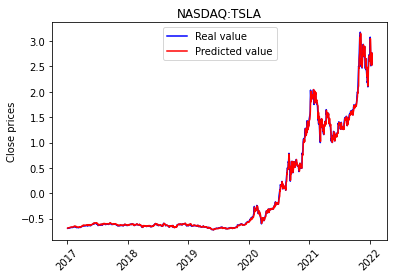

In [190]:
predict_stock_value('TSLA')


Evaluating AAPL Prediction
Mean Absolute Error (MAE): 0.025062252283502465
Mean Squared Error (MSE): 0.0015902681226605169
Mean Absolute Percentage Error (MAPE): 0.09276621745628794
R^2: 0.9984097318773395


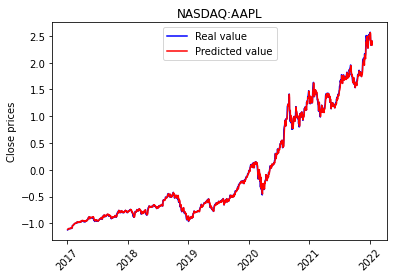

In [191]:
predict_stock_value('AAPL')


Evaluating GOOGL Prediction
Mean Absolute Error (MAE): 0.028619416385021024
Mean Squared Error (MSE): 0.0018640570263195168
Mean Absolute Percentage Error (MAPE): 0.19212979716822226
R^2: 0.9981359429736805


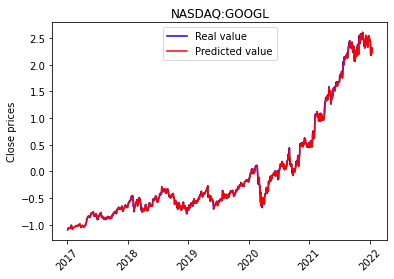

In [192]:
predict_stock_value('GOOGL')


Evaluating MSFT Prediction
Mean Absolute Error (MAE): 0.024259465129702815
Mean Squared Error (MSE): 0.0014857743092317342
Mean Absolute Percentage Error (MAPE): 0.1285849869840237
R^2: 0.9985142256907683


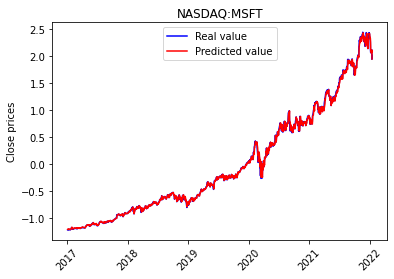

In [193]:
predict_stock_value('MSFT')


Evaluating GOOGL Prediction
Mean Absolute Error (MAE): 0.028619416385021024
Mean Squared Error (MSE): 0.0018640570263195168
Mean Absolute Percentage Error (MAPE): 0.19212979716822226
R^2: 0.9981359429736805


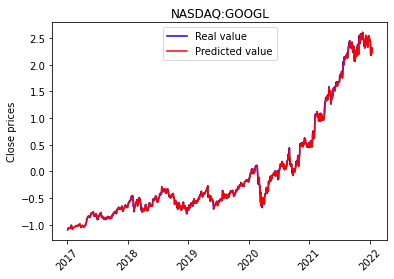

In [194]:
predict_stock_value('GOOGL')